In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [5]:
init_weight_dict = {'conv1.weight': (0.002619123551994562, 0.12110346555709839), 'conv1.bias': (-0.044515371322631836, 0.10650832951068878), 'conv2.weight': (-0.014031852595508099, 0.06525229662656784), 'conv2.bias': (-0.01866402104496956, 0.06726235151290894), 'conv3.weight': (-0.014420724473893642, 0.06095079332590103), 'conv3.bias': (-0.026280079036951065, 0.07677483558654785), 'conv4.weight': (-0.012442529201507568, 0.056499700993299484), 'conv4.bias': (-0.009047136642038822, 0.09178731590509415), 'conv5.weight': (-0.010098770260810852, 0.05377247557044029), 'conv5.bias': (0.008716950193047523, 0.12336630374193192), 'conv6.weight': (-0.007273155730217695, 0.04424232989549637), 'conv6.bias': (0.02756168134510517, 0.1408526748418808), 'fc1.weight': (-0.0010197607334703207, 0.10992096364498138), 'fc1.bias': (0.06867112219333649, 0.165935680270195), 'fc2.weight': (-0.025755703449249268, 0.10916614532470703), 'fc2.bias': (-0.010193572379648685, 0.18183904886245728)}

In [6]:
class coldBayesianBaselineCNN(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        # Bayesian Conv layers with better priors
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=3, padding=1)
        # Use smaller std for better initialization (Xavier-like)
        self.conv1.weight = PyroSample(dist.Normal(0., 0.1).expand([32, 3, 3, 3]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 0.1).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=3, padding=1)
        self.conv2.weight = PyroSample(dist.Normal(0., 0.1).expand([64, 32, 3, 3]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 0.1).expand([64]).to_event(1))

        self.conv3 = PyroModule[nn.Conv2d](64, 128, kernel_size=3, padding=1)
        self.conv3.weight = PyroSample(dist.Normal(0., 0.1).expand([128, 64, 3, 3]).to_event(4))
        self.conv3.bias = PyroSample(dist.Normal(0., 0.1).expand([128]).to_event(1))

        self.conv4 = PyroModule[nn.Conv2d](128, 128, kernel_size=3, padding=1)
        self.conv4.weight = PyroSample(dist.Normal(0., 0.1).expand([128, 128, 3, 3]).to_event(4))
        self.conv4.bias = PyroSample(dist.Normal(0., 0.1).expand([128]).to_event(1))

        self.conv5 = PyroModule[nn.Conv2d](128, 64, kernel_size=3, padding=1)
        self.conv5.weight = PyroSample(dist.Normal(0., 0.1).expand([64, 128, 3, 3]).to_event(4))
        self.conv5.bias = PyroSample(dist.Normal(0., 0.1).expand([64]).to_event(1))

        self.conv6 = PyroModule[nn.Conv2d](64, 32, kernel_size=3, padding=1)
        self.conv6.weight = PyroSample(dist.Normal(0., 0.1).expand([32, 64, 3, 3]).to_event(4))
        self.conv6.bias = PyroSample(dist.Normal(0., 0.1).expand([32]).to_event(1))

        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Bayesian FC layers with better priors
        self.fc1 = PyroModule[nn.Linear](32, 64)
        # Use Xavier-like initialization: std = sqrt(2 / (fan_in + fan_out))
        self.fc1.weight = PyroSample(dist.Normal(0., 0.2).expand([64, 32]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.1).expand([64]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](64, num_classes)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.2).expand([num_classes, 64]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.1).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = self.global_avg_pool(x)  # (B, 32, 1, 1)
        x = x.view(x.size(0), -1)    # (B, 32)
        x = F.relu(self.fc1(x))      # (B, 64)
        logits = self.fc2(x)         # (B, num_classes)

        with pyro.plate("data", x.size(0)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [7]:
# make a similar model with priors from init_weight_dict
class BayesianBaselineCNN(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        # Bayesian Conv layers with better priors
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=3, padding=1)
        self.conv1.weight = PyroSample(dist.Normal(init_weight_dict['conv1.weight'][0], init_weight_dict['conv1.weight'][1]).expand([32, 3, 3, 3]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(init_weight_dict['conv1.bias'][0], init_weight_dict['conv1.bias'][1]).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=3, padding=1)
        self.conv2.weight = PyroSample(dist.Normal(init_weight_dict['conv2.weight'][0], init_weight_dict['conv2.weight'][1]).expand([64, 32, 3, 3]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(init_weight_dict['conv2.bias'][0], init_weight_dict['conv2.bias'][1]).expand([64]).to_event(1))

        self.conv3 = PyroModule[nn.Conv2d](64, 128, kernel_size=3, padding=1)
        self.conv3.weight = PyroSample(dist.Normal(init_weight_dict['conv3.weight'][0], init_weight_dict['conv3.weight'][1]).expand([128, 64, 3, 3]).to_event(4))
        self.conv3.bias = PyroSample(dist.Normal(init_weight_dict['conv3.bias'][0], init_weight_dict['conv3.bias'][1]).expand([128]).to_event(1))

        self.conv4 = PyroModule[nn.Conv2d](128, 128, kernel_size=3, padding=1)
        self.conv4.weight = PyroSample(dist.Normal(init_weight_dict['conv4.weight'][0], init_weight_dict['conv4.weight'][1]).expand([128, 128, 3, 3]).to_event(4))
        self.conv4.bias = PyroSample(dist.Normal(init_weight_dict['conv4.bias'][0], init_weight_dict['conv4.bias'][1]).expand([128]).to_event(1))

        self.conv5 = PyroModule[nn.Conv2d](128, 64, kernel_size=3, padding=1)
        self.conv5.weight = PyroSample(dist.Normal(init_weight_dict['conv5.weight'][0], init_weight_dict['conv5.weight'][1]).expand([64, 128, 3, 3]).to_event(4))
        self.conv5.bias = PyroSample(dist.Normal(init_weight_dict['conv5.bias'][0], init_weight_dict['conv5.bias'][1]).expand([64]).to_event(1))

        self.conv6 = PyroModule[nn.Conv2d](64, 32, kernel_size=3, padding=1)
        self.conv6.weight = PyroSample(dist.Normal(init_weight_dict['conv6.weight'][0], init_weight_dict['conv6.weight'][1]).expand([32, 64, 3, 3]).to_event(4))
        self.conv6.bias = PyroSample(dist.Normal(init_weight_dict['conv6.bias'][0], init_weight_dict['conv6.bias'][1]).expand([32]).to_event(1))

        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Bayesian FC layers with better priors
        self.fc1 = PyroModule[nn.Linear](32, 64)
        self.fc1.weight = PyroSample(dist.Normal(init_weight_dict['fc1.weight'][0], init_weight_dict['fc1.weight'][1]).expand([64, 32]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(init_weight_dict['fc1.bias'][0], init_weight_dict['fc1.bias'][1]).expand([64]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](64, num_classes)
        self.fc2.weight = PyroSample(dist.Normal(init_weight_dict['fc2.weight'][0], init_weight_dict['fc2.weight'][1]).expand([num_classes, 64]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(init_weight_dict['fc2.bias'][0], init_weight_dict['fc2.bias'][1]).expand([num_classes]).to_event(1))
    
    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)    
        with pyro.plate("data", x.size(0)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits
    


In [8]:
def load_data(batch_size=64):  # Changed from 54 to 64 to match deterministic CNN
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    torch.manual_seed(42)
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [9]:
import pyro
import pyro.infer
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import tqdm

# 1. Instantiate model and guide - fix device consistency
num_classes = 10
bayesian_model = BayesianBaselineCNN(num_classes=num_classes).to(device)  # Use .to(device) instead of .cuda()
guide = AutoDiagonalNormal(bayesian_model)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

# 3. Training function
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")


In [ ]:
#bayesian_model.to(device)
#guide.to(device)

In [10]:
# Clear parameter store before training
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
train_svi(bayesian_model, guide, svi, train_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 400/400 [02:13<00:00,  3.00it/s]


Epoch 1 - ELBO Loss: 127693.7455


Epoch 2/10: 100%|██████████| 400/400 [01:12<00:00,  5.54it/s]


Epoch 2 - ELBO Loss: 64795.8769


Epoch 3/10: 100%|██████████| 400/400 [01:12<00:00,  5.53it/s]


Epoch 3 - ELBO Loss: 34242.2185


Epoch 4/10: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s]


Epoch 4 - ELBO Loss: 18377.6966


Epoch 5/10: 100%|██████████| 400/400 [01:13<00:00,  5.46it/s]


Epoch 5 - ELBO Loss: 10109.6873


Epoch 6/10: 100%|██████████| 400/400 [01:13<00:00,  5.46it/s]


Epoch 6 - ELBO Loss: 5795.6476


Epoch 7/10: 100%|██████████| 400/400 [01:11<00:00,  5.61it/s]


Epoch 7 - ELBO Loss: 3608.2430


Epoch 8/10: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s]


Epoch 8 - ELBO Loss: 2544.1370


Epoch 9/10: 100%|██████████| 400/400 [01:11<00:00,  5.61it/s]


Epoch 9 - ELBO Loss: 2037.0722


Epoch 10/10: 100%|██████████| 400/400 [01:11<00:00,  5.61it/s]

Epoch 10 - ELBO Loss: 1813.4895


In [11]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_svi(model, guide, test_loader, num_samples=10):
    model.eval()
    correct = 0
    total = 0

    #device = next(model.parameters()).device  # Get the device where the model is allocated

    with torch.no_grad():  # Add no_grad for efficiency
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)  # Fix: move to device

            # Accumulate logits from multiple samples
            logits_mc = torch.zeros(num_samples, images.size(0), model.fc2.out_features).to(device)

            for i in range(num_samples):
                # Sample from the guide (posterior) and replay through model
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            # Average the logits across samples
            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy over {num_samples} MC samples: {accuracy * 100:.2f}%")
    return accuracy


In [12]:
evaluate_svi(bayesian_model, guide, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

Accuracy over 10 MC samples: 11.06%


0.11055555555555556

In [13]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape}")
    print(value)


AutoDiagonalNormal.loc: torch.Size([335850])
Parameter containing:
tensor([ 0.0090, -0.0033,  0.0113,  ...,  0.0167, -0.0030, -0.0083],
       requires_grad=True)
AutoDiagonalNormal.scale: torch.Size([335850])
tensor([0.1180, 0.1228, 0.1182,  ..., 0.1712, 0.1739, 0.1659],
       grad_fn=<SoftplusBackward0>)


In [14]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, test_loader, num_samples=10):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc2.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [15]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


In [16]:
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[115  31 116  39  43  14  23  79  60  80]
 [129  28 103  42  44  22  19  62  50 101]
 [135  36  85  38  33  18  18  69  75  93]
 [ 95  27  86  26  43  19  13  81  43  67]
 [ 99  33  94  24  32  17  12  61  55  73]
 [ 86  16  56  28  29  14  12  44  46  69]
 [ 84  36  96  32  29  13  15  61  57  77]
 [111  41  97  33  50  13  24  93  45  93]
 [110  27  81  24  31  14  11  67  65  70]
 [126  27 102  40  44  18  15  75  66  87]]


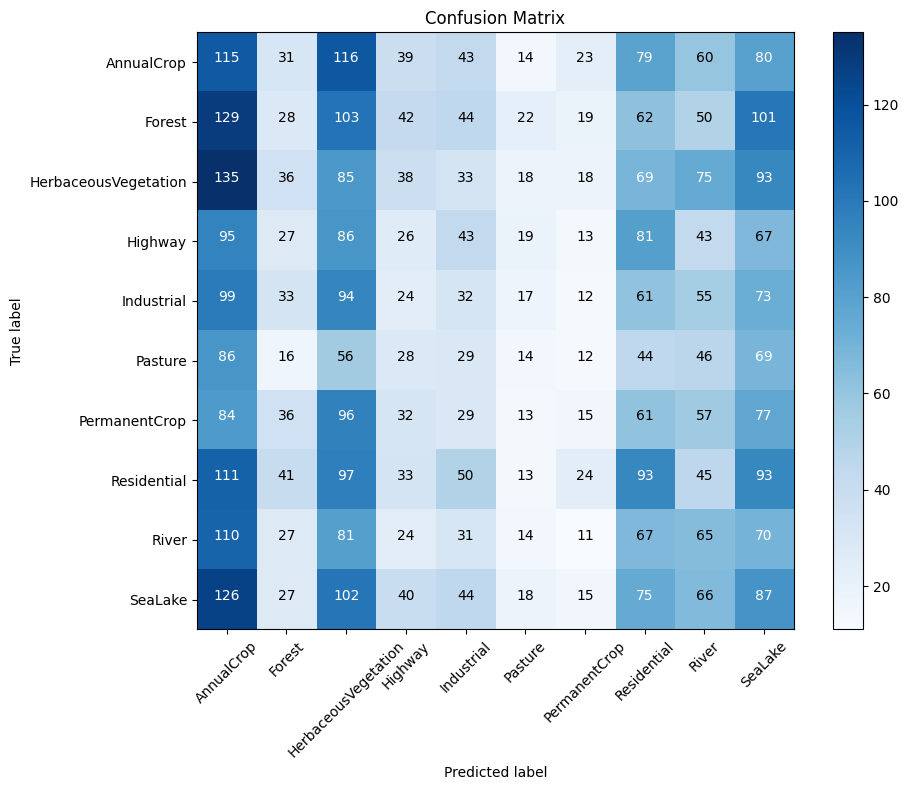

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [ ]:
# show 1 sample prediction and put the label on the image in matplotlib
import matplotlib.pyplot as plt

def show_sample_prediction(model, test_loader, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    logits_mc = torch.zeros(num_samples, images.size(0), model.fc2.out_features).to(device)

    for i in range(num_samples):
        guide_trace = pyro.poutine.trace(guide).get_trace()
        replayed_model = pyro.poutine.replay(model, trace=guide_trace)
        logits = replayed_model(images)
        logits_mc[i] = logits

    avg_logits = logits_mc.mean(dim=0)
    predictions = torch.argmax(avg_logits, dim=1)

    #print the logits and its label in descending order
    sorted_logits, sorted_indices = torch.sort(avg_logits[0], descending=True)
    print("Logits (sorted):")
    for i in range(len(sorted_logits)):
        print(f"Class {sorted_indices[i].item()}: {sorted_logits[i].item()}")

    # for the correct label, print in which rank is the label in the sorted logits
    correct_label = labels[0].item()
    correct_rank = (sorted_indices == correct_label).nonzero(as_tuple=True)[0].item()
    print(f"Correct label {correct_label} is at rank {correct_rank + 1} in the sorted logits.")

    # Show the first image and its prediction
    plt.imshow(images[0].cpu().permute(1, 2, 0)* 0.1137 + 0.4082)
    plt.title(f"Predicted: {predictions[0]}, True: {labels[0]} \nRank: {correct_rank + 1}")
    plt.axis('off')
    plt.show()


In [83]:
def comprehensive_prediction_check(model, guide, test_loader, num_samples=10):
    model.eval()
    
    # Check multiple samples from posterior
    all_preds_single = []
    all_preds_mc = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Single sample prediction (your current method)
            guide_trace = pyro.poutine.trace(guide).get_trace()
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)
            logits_single = replayed_model(images)
            preds_single = torch.argmax(logits_single, dim=1)
            all_preds_single.extend(preds_single.cpu().numpy())
            
            # Multiple samples (Monte Carlo)
            logits_mc = torch.zeros(num_samples, images.size(0), model.fc2.out_features).to(device)
            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits_mc[i] = replayed_model(images)
            
            avg_logits = logits_mc.mean(dim=0)
            preds_mc = torch.argmax(avg_logits, dim=1)
            all_preds_mc.extend(preds_mc.cpu().numpy())
            
            break  # Just check first batch
    
    print("Single sample prediction distribution:", np.bincount(all_preds_single))
    print("MC average prediction distribution:", np.bincount(all_preds_mc))
    #print the true labels prediction as well
    true_labels = labels.cpu().numpy()
    print("True labels distribution:", np.bincount(true_labels))

    # Check if guide has learned meaningful parameters
    print("\nGuide parameter statistics:")
    for name, param in pyro.get_param_store().items():
        if 'loc' in name:
            print(f"{name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")
        elif 'scale' in name:
            print(f"{name}: mean={param.mean().item():.4f}, min={param.min().item():.4f}, max={param.max().item():.4f}")
    
    return None

In [84]:
# Run comprehensive check
comprehensive_prediction_check(bayesian_model, guide, test_loader)

Single sample prediction distribution: [ 0  0 54]
MC average prediction distribution: [ 0  0 54]
True labels distribution: [9 7 7 5 5 4 5 3 2 7]

Guide parameter statistics:
AutoDiagonalNormal.loc: mean=-0.0120, std=0.0059
AutoDiagonalNormal.scale: mean=0.0582, min=0.0436, max=0.1739


In [85]:
# make the function so I can determine the batch number to do comprehensive prediction check
def comprehensive_prediction_check_batch(model, guide, test_loader, batch_num=0, num_samples=10):
    model.eval()
    
    # Check multiple samples from posterior
    all_preds_single = []
    all_preds_mc = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i == batch_num:
                images = images.to(device)
                
                # Single sample prediction (your current method)
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits_single = replayed_model(images)
                preds_single = torch.argmax(logits_single, dim=1)
                all_preds_single.extend(preds_single.cpu().numpy())
                
                # Multiple samples (Monte Carlo)
                logits_mc = torch.zeros(num_samples, images.size(0), model.fc2.out_features).to(device)
                for j in range(num_samples):
                    guide_trace = pyro.poutine.trace(guide).get_trace()
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    logits_mc[j] = replayed_model(images)
                
                avg_logits = logits_mc.mean(dim=0)
                preds_mc = torch.argmax(avg_logits, dim=1)
                all_preds_mc.extend(preds_mc.cpu().numpy())
                
                break  # Just check the specified batch
    
    print(f"Batch {batch_num} - Single sample prediction distribution:", np.bincount(all_preds_single))
    print(f"Batch {batch_num} - MC average prediction distribution:", np.bincount(all_preds_mc))
    
    # Check if guide has learned meaningful parameters
    print("\nGuide parameter statistics:")
    for name, param in pyro.get_param_store().items():
        if 'loc' in name:
            print(f"{name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")
        elif 'scale' in name:
            print(f"{name}: mean={param.mean().item():.4f}, min={param.min().item():.4f}, max={param.max().item():.4f}")
    
    return None

In [90]:
# Example usage for batch 1
comprehensive_prediction_check_batch(bayesian_model, 
                                     guide, 
                                     test_loader, 
                                     batch_num=3, 
                                     num_samples=10)

Batch 3 - Single sample prediction distribution: [ 0  0 54]
Batch 3 - MC average prediction distribution: [ 0  0  0  0  0  0  0  0  0 54]

Guide parameter statistics:
AutoDiagonalNormal.loc: mean=-0.0120, std=0.0059
AutoDiagonalNormal.scale: mean=0.0582, min=0.0436, max=0.1739


Logits (sorted):
Class 9: -0.14204616844654083
Class 0: -0.16378267109394073
Class 4: -0.18160323798656464
Class 3: -0.18629798293113708
Class 7: -0.19541509449481964
Class 1: -0.20518681406974792
Class 6: -0.21450486779212952
Class 8: -0.23356668651103973
Class 5: -0.2940385937690735
Class 2: -0.3178873062133789
Correct label 0 is at rank 2 in the sorted logits.


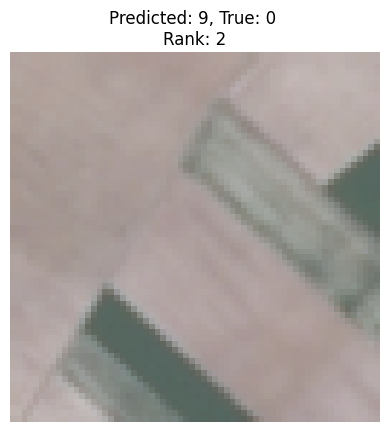

In [94]:
show_sample_prediction(bayesian_model, test_loader, num_samples=10)

## Using Predictive

In [91]:
from pyro.infer import Predictive

train_loader, test_loader = load_data()
#x_test, y_test = next(iter(test_loader))
predictive = Predictive(bayesian_model, guide=guide, num_samples=5, return_sites=["_RETURN"])

all_preds = []
all_labels = []

for x_batch, y_batch in tqdm(test_loader):
    batch_preds = predictive(x_batch)["_RETURN"]  # shape: (num_samples, batch_size, ...)
    batch_preds = torch.softmax(batch_preds, dim=-1)
    mean_preds = batch_preds.float().mean(dim=0).squeeze()  # shape: (batch_size, num_classes)
    mean_preds = mean_preds.argmax(dim=1)  # shape: (batch_size,)
    all_preds.append(mean_preds)
    all_labels.append(y_batch)

# Concatenate along the batch dimension
all_preds = torch.cat(all_preds, dim=0)   # shape: (total_test_samples, ...)
all_labels = torch.cat(all_labels, dim=0) # shape: (total_test_samples, ...)

100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


In [93]:
# print accuracy of all_preds and all_labels
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels.cpu().numpy(), all_preds.cpu().numpy())
print(f"Accuracy of Bayesian model on test set: {accuracy * 100:.2f}%")

Accuracy of Bayesian model on test set: 10.19%
